# Projecting heat pump costs

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from figures import sciencify_plotly_fig

In [2]:
learning_rates = [
    3.5, 5.5, 7.5, # renaldi et. al 2020
    25.55, 26, 26.46, # Weiss et.al. 2008
    4.8, 11.1, 17.4 # Louwen et.al 2018
]
lr_1 = np.mean(learning_rates) - np.std(learning_rates)
lr_2 = np.mean(learning_rates) 
lr_3 = np.mean(learning_rates) + np.std(learning_rates)
lrs = [5.5, 7.5, 11.1, 26, ]#np.linspace(5.5,26,5)

In [4]:
global_installed_hps = [
    # 180, 600, 1800 # IEA global net zero (millions of installed heat pump)
    180,  
    600, 
    1800 
]
heat_pump_installations = np.linspace(global_installed_hps[0], global_installed_hps[-1], 30)

hp_price_0 = 770.751 # price at 2020


def price_reduction(x, lr, p0=1):
    b = -np.log((1 - lr / 100)) / np.log(2)
    return p0 * x**-b


def lr_based_cost_factors(x, lr, p0=1):
    # sets first (2020) data point to 1
    price_factors = price_reduction(x, lr, p0)
    return price_factors / list(price_factors)[0]


future_prices = np.array(
    [lr_based_cost_factors(heat_pump_installations, lr, p0=hp_price_0) for lr in lrs]
).T * hp_price_0
future_prices = pd.DataFrame(
    future_prices,
    index=heat_pump_installations, #+ 180,
    columns=[f"{lr:.1f}%" for lr in lrs],
)
fig = px.line(future_prices)
fig.update_layout(
    yaxis_title="Specific investment (CAD/kW)",
    xaxis_title="Cumulative installations (mio)",
    yaxis_range=(0, hp_price_0 * 1.1),
    width=400,
    height=400,
    xaxis=dict(
        tickmode="array",
        tickvals=[
            180,
            600,
            1200,
            1800,
        ],
        ticktext=[
            180,
            600,
            1200,
            1800,
        ],
    ),
    font=dict(family="cm", size=14),
)
fig = sciencify_plotly_fig(fig)
fig.add_vrect(
    560,
    640,
    annotation=dict(text="2030", textangle=-90),
    fillcolor="#ffffff",
    opacity=0.4,
)
fig.add_vrect(
    1160,
    1240,
    annotation=dict(text="2040", textangle=-90),
    fillcolor="#ffffff",
    opacity=0.4,
)
fig.add_vrect(
    1760,
    1840,
    annotation=dict(text="2050", textangle=-90),
    fillcolor="#ffffff",
    opacity=0.4,
)


fig.update_layout(
    legend=dict(
        title="LR",
        x=0.3,
        y=0.02,
        bordercolor="gray",
        borderwidth=2,
        # font=dict(size=20)
    ),
    margin={"r": 20, "t": 10, "b": 0, "l": 0},
)
# import plotly.io as pio
fig.write_image("figures/heat_pump_cost_projections.pdf")
fig.write_image("figures/heat_pump_cost_projections.svg")
fig

In [6]:
# # executed at commit: 505378d16c8d4bc833763686ccb4104546d006ed
future_prices["year"] = np.arange(2020, 2050)
future_prices = future_prices.set_index("year")#.loc[range(2020,2050),:]
future_prices

# # according to this phd thesis https://d-nb.info/1021976628/34 p.56, pellet boilers could have learning rate of 7 or 10%
# # which is currently ignored
# # another source for hp learning rates: https://www.eusustel.be/public/documents_publ/WP/WP5/SAPIENTIA-Final%20Report.pdf p 40f, 452
# # ~20%, source is from 2005 SYSTEM ANALYSIS FOR PROGRESS AND INNOVATION IN ENERGY TECHNOLOGIES FOR INTEGRATED ASSESSMENT 
# # Research Project DG RES, 5th Framework Programme
specific_costs = pd.read_csv("data/canada/heat_tech_params.csv", index_col=list(range(2)))#.query("variable=='specific_cost'").drop("variable", axis=1).set_index("year")

for i, row in future_prices.iterrows():
    specific_costs.at[(i,"specific_cost"),"Heat pump"] = row["11.1%"]
    if i > 2020:
        for other_tech in ['Electric furnace', 'Gas furnace', 'Oil furnace','Wood or wood pellets furnace']:
            # take last available cost param if not present... 
            if (i,"specific_cost") not in specific_costs.index:
                specific_costs.at[(i,"specific_cost"),other_tech] = specific_costs.loc[(i-1,"specific_cost"),other_tech]
            else:
                # or if it is empty. This happens often, only the Heat pump column was written previously
                if pd.isna(specific_costs.at[(i,"specific_cost"),other_tech]):
                    specific_costs.at[(i,"specific_cost"),other_tech] = specific_costs.loc[(i-1,"specific_cost"),other_tech]

specific_costs.to_csv("data/canada/heat_tech_params.csv")
specific_costs.tail()

,,Electric furnace,Gas furnace,Heat pump,Oil furnace,Wood or wood pellets furnace
year,variable,,,,,
2045,specific_cost,91.817,209.172,533.262017,209.477,648.804
2046,specific_cost,91.817,209.172,530.119484,209.477,648.804
2047,specific_cost,91.817,209.172,527.100298,209.477,648.804
2048,specific_cost,91.817,209.172,524.195768,209.477,648.804
2049,specific_cost,91.817,209.172,521.398072,209.477,648.804


# Technology Input data

In [4]:
import pandas as pd
from scipy.optimize import curve_fit

def lin(x,m,b):
    return m*x+b

tech_df = pd.read_csv("data/canada/eia_building_appl_cost_mean.csv").set_index(["year","variable"]).sort_index(level=1)#.interpolate()
# tech_df.to_csv("data/canada/eia_building_appl_cost_mean.csv")


In [5]:

# tech_df.loc[:,"specific_cost",:] = (tech_df.loc[:,"specific_cost",:]*1/0.7688).values
# tech_df.loc[:,"specific_fom_cost",:] = (tech_df.loc[:,"specific_fom_cost",:]*1/0.7688).values
# tech_df.round(3).to_csv("data/canada/eia_building_appl_cost_mean.csv")
# years = tech_df.reset_index()["year"].to_list()

# for var in tech_df.reset_index()["variable"].unique():
#     # print(var)
#     c_df = tech_df.loc[:,var,:].reset_index().query("year < 2023")
#     for tech in c_df.columns:
#         # print("\t",tech)
#         if tech=="year":
#             continue
#         is_na = c_df[tech].isna()
#         p,v = curve_fit(lin, c_df.loc[~is_na,"year"], c_df.loc[~is_na,tech])
#         if 2000 in tech_df.index:
#             tech_df.loc[(2000,var),tech] = lin(2000,*p)
#         else:    
#             tech_df.at[(2000,var),tech] = lin(2000,*p)

#         for year in c_df.loc[is_na,"year"]:
#             next_year = years[years.index(year)+1]
#             tech_df.loc[(year,var),tech] = tech_df.loc[(next_year,var),tech]


# tech_df = tech_df.sort_index()
# tech_df.head()


In [159]:
# tech_df.sort_index(level=1).to_csv("data/canada/eia_building_appl_cost_mean.csv")

## interpolating input data

In [6]:
import pandas as pd

# tech_params = pd.read_csv("data/canada/heat_tech_params.csv")
# tech_params = tech_params.set_index(["variable","year"])
# columns = ['Electric furnace', 'Gas furnace', 'Heat pump', 'Oil furnace',
#        'Wood or wood pellets furnace']
unique_vars = ['specific_fom_cost', 'specific_cost', #'specific_fuel_emission',
       'efficiency', 'lifetime', "annuity_factor"]

missing_years = [y for y in range(2000,2021) if y not in tech_df.index]
empty_frame = pd.DataFrame(index=pd.MultiIndex.from_product([missing_years,unique_vars]), columns=tech_df.columns)
inter_p_df = pd.concat([empty_frame,tech_df]).sort_index(level=1).interpolate()
inter_p_df.swaplevel().round(3).swaplevel().sort_index(level=1)#.to_csv("data/canada/heat_tech_params.csv")

## performance enhancements

In [19]:
from components.model import TechnologyAdoptionModel
from functools import partial
from decision_making.mcda import normalize, calc_score
from numba import njit

model = TechnologyAdoptionModel(10,"Ontario")
agent = model.schedule.agents[0]

def calc_score_new(row: pd.Series, weights: dict) -> float:
    """calculates the (mcda) score of the `row` using the `weights` by vector
    multiplication. The index of `row` (or the DataFrame on which `.apply()` is used)
    and the keys of the `weights` must match.
    """
    weight_series = pd.Series(weights)

    # ensure each index appears in both frames
    assert all(idx in weight_series.index for idx in row.index)
    # sort both series to ensure alignment
    row.sort_index(inplace=True)
    weight_series.sort_index(inplace=True)

    return row.values @ weight_series.values



def calc_scores(
    self, score_func
):
    techs_df = self.heat_techs_df
    techs_df["attitude"] = self.tech_attitudes
    techs_df["attitude"] = normalize(techs_df["attitude"] + 1)
    
    # calculate scores
    p_normalize = partial(normalize, direction=-1)
    techs_df.loc[:, ["cost_norm"]] = (
        techs_df[["annual_cost"]].apply(p_normalize).values
    )
    techs_df["total_score"] = techs_df[
        ["emissions_norm", "cost_norm", "attitude"]
    ].apply(
        score_func,
        axis=1,
        weights=self.criteria_weights,
    )
    return techs_df

# agent.calc_scores = partial(calc_scores, self=agent, score_func=calc_score_new)
# agent.calc_scores()[["attitude", "emissions_norm", "cost_norm","total_score"]]
%timeit calc_scores(agent, calc_score_new)
%timeit calc_scores(agent, calc_score)

In [ ]:
weight_d =     {
        "cost_norm": 0.4650762644948514,
        "emissions_norm": 0.13842755443143467,
        "attitude": 0.3964961810737139,
    }
%timeit pd.Series(weight_d)
%timeit weight_df = pd.DataFrame(weight_d.values(), columns=["weights"], index=weight_d.keys())

In [ ]:
import numpy as np
partial_score = pd.Series(
    {
        "emissions_norm": 0.61,
        "cost_norm": 1.00,
        "attitude": 0.00,
    }
)
weights = pd.Series(
    weight_d
)

@njit
def calc_score_numba(weights, values):
    score = 0
    for i,w in enumerate(weights):
        score += w * values[i]
    return score

le_vals = np.array(list(weight_d.values()))
# %timeit partial_score@weights
%timeit -n 100000 partial_score.values@weights.values
%timeit -n 100000 calc_score_numba(np.array(list(weight_d.values())),np.array(list(weight_d.values())))

# Canadas Energy future - data

In [ ]:
1 # $/GJ
100 # ct/GJ
100* 3600 # ct/ GWh
100* 3600 / 1e6# ct/ kWh


In [ ]:
1/3600

In [ ]:
import plotly.express as px
import pandas as pd
end_use_prices = pd.read_csv("data/canada/end-use-prices-2023_ct_per_kWh.csv", index_col=0)

fig = px.line(
    end_use_prices.query("Region=='Ontario' and Sector=='Residential'"),
    x="Year",
    y="Value",
    color="Variable",
    facet_col="Scenario",
    template="plotly"
)
fig.update_layout(
    title="Residential energy prices",
    yaxis_title="Energy price (ct/kWh)"
)


In [ ]:
import pandas as pd
from data.canada import fuel_prices, gas_prices

end_use_prices = pd.read_csv(
    "data/canada/end-use-prices-2023_ct_per_kWh.csv", index_col=0
)
future_gas_prices = end_use_prices.query(
    f"Scenario=='Global Net-zero' and Sector=='Residential' and Variable=='Natural Gas'"# and Year>{max(gas_prices["Year"])}"
)[["Region", "Value", "Year", "Variable"]]
future_gas_prices = future_gas_prices.rename(
    {"Region": "GEO", "Value": "Price (ct/kWh)", "Variable": "Type of fuel"}, axis=1
)
gas_prices = pd.concat([gas_prices, future_gas_prices])



In [ ]:
import pandas as pd
from data.canada import all_fuel_prices

end_use_prices = pd.read_csv(
    "data/canada/end-use-prices-2023_ct_per_kWh.csv", index_col=0
).query(
    f"Scenario=='Global Net-zero' and Sector=='Residential'").rename(
    {"Region": "GEO", "Value": "Price (ct/kWh)", "Variable": "Type of fuel"}, axis=1
)[["Year","GEO","Price (ct/kWh)","Type of fuel"]]
print(end_use_prices["Type of fuel"].unique())
print(all_fuel_prices.reset_index()["Type of fuel"].unique())
# pd.concat([all_fuel_prices.reset_index(), end_use_prices]).set_index(["Type of fuel","Year"])

In [ ]:
all_fuel_prices.index[:5],end_use_prices.index[:5]

In [ ]:


# gas_prices
all_the_prices = pd.concat([all_fuel_prices.reset_index(), end_use_prices]).set_index(["GEO","Year","Type of fuel"])
duplicates = all_the_prices.index.duplicated()
all_the_prices.reset_index().loc[~duplicates,"Type of fuel"].unique()
# pd.merge(left=all_fuel_prices, right=end_use_prices, on=["GEO","Year"]).set_index(["GEO","Year","Type of fuel"]).index.duplicated

## Geographical data


In [ ]:
import geopandas as gpd

canada_gdf = gpd.read_file("data/canada/canada.geojson")
canada_gdf["centroid"]= canada_gdf["geometry"].apply(lambda x: x.centroid)
ax = canada_gdf.plot()
ax.scatter(canada_gdf["centroid"].x,canada_gdf["centroid"].y, color="red")
# this is used to get the weather data

In [ ]:
# centroids are not a good approximation. Use population centers instead
import shapely as sh

pop_centers = {
    "Quebec": (45.53312807333965, -73.61511415981778), # Montreal
    "Newfoundland and Labrador": (47.55902628296887, -52.740148813553624), # St. Johns
    "British Columbia": (49.26885406028422, -123.11713372323813), # vancouver
    "Nunavut": (63.747654358220444, -68.5170967002665), # Iqualit
    "Northwest Territories": (62.45269464084662, -114.36896850628257), # Yellowknife
    "New Brunswick": (46.09989553810743, -64.77416722665333), # Moncton
    "Nova Scotia": (44.64958366154484, -63.58093792618714), # Halifax  
    "Saskatchewan": (50.449703126577795, -104.61930722801765), # Regina
    "Alberta": (51.03649663454597, -114.07009597159944), # Calgary
    "Prince Edward Island": (46.242364438015976, -63.12712300014809), # Charlottetown
    "Yukon": (60.71835688260373, -135.05313593078967), # Whitehorse
    "Manitoba": (49.8908370535123, -97.13705628523745), # Winnipeg
    "Ontario": (43.75668261210348, -79.43114766451536), # Toronto
}
def create_point(name):
    return sh.Point(pop_centers[name])

canada_gdf["pop_center"] = canada_gdf["name"].apply(create_point)

ax = canada_gdf.plot()

ax.scatter(canada_gdf["pop_center"].apply(lambda p: p.y),canada_gdf["pop_center"].apply(lambda p: p.x), color="red")

In [ ]:
import requests
import time
from io import StringIO
import pandas as pd

# canada_gdf = gpd.read_file(f"{repo_root}/data/canada/canada.geojson")
# canada_gdf["centroid"]= canada_gdf["geometry"].apply(lambda x: x.centroid)
# _jrc_url = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat=49.220&lon=-123.055&raddatabase=PVGIS-NSRDB&browser=1&outputformat=csv&userhorizon=&usehorizon=1&angle=&aspect=&startyear=2013&endyear=2013&mountingplace=free&optimalinclination=0&optimalangles=1&js=1&select_database_hourly=PVGIS-NSRDB&hstartyear=2013&hendyear=2013&trackingtype=0&hourlyoptimalangles=1&pvcalculation=1&pvtechchoice=crystSi&peakpower=1&loss=14&components=1"
# url = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={lat}&lon={lon}&raddatabase=PVGIS-NSRDB&browser=1&outputformat=csv&userhorizon=&usehorizon=1&angle=&aspect=&startyear=2013&endyear=2013&mountingplace=free&optimalinclination=0&optimalangles=1&js=1&select_database_hourly=PVGIS-NSRDB&hstartyear=2013&hendyear=2013&trackingtype=0&hourlyoptimalangles=1&pvcalculation=1&pvtechchoice=crystSi&peakpower=1&loss=14&components=1"

# df = pd.DataFrame()
# responses = []
# for point in canada_gdf.pop_center:
#     province_url = url.format(lon=point.y, lat=point.x)
#     response = requests.get(province_url)
#     responses.append(response)
#     time.sleep(0.1)
# for i, resp in enumerate(responses):
#     province = canada_gdf["name"][i]
#     try:
#         c_df = pd.read_csv(StringIO(resp.text), header=8)
#         df[province] = c_df["T2m"]
#     except Exception as e:
#         print("error on",province)

# df["Canada"] = df.mean(axis=1)


In [ ]:
# df.dropna(inplace=True)#.to_csv("data/canada/CA_provinces_temperatures.csv")

In [ ]:
# df["time"] = pd.date_range("2013", freq="h", periods=8760)
# df.set_index("time", inplace=True)
# df.to_csv("data/canada/CA_provinces_temperatures.csv")

In [ ]:
# df = pd.read_csv(f"{repo_root}/data/canada/CA_provinces_temperatures.csv")
# df.set_index("time",inplace=True)
# from data.canada.timeseries import normalize_temperature_diff
# max_norm_T_df = pd.DataFrame()
# for col in df.columns:
#     for T in range(285,300):
#         T_K = T + 0.15
#         norm_diff = normalize_temperature_diff(df[col]+273.15,T_K)
#         max_norm_T_df.at[T_K,col] =  norm_diff.max()
# max_norm_T_df.index.set_names(["T_set"], inplace=True)
# # max_norm_T_df
# max_norm_T_df.to_csv("data/canada/CA_provinces_max_norm_T.csv")

In [ ]:
# could be more precise with this data, but probably not worth the effort
# https://open.canada.ca/data/en/dataset/c6c48391-fd2f-4d8a-93c8-eb74f58a859b


# using income-energy fit as expectation value only


In [94]:
import plotly.express as px
from data.canada import (
    uncertain_demand_from_income_and_province,
    get_beta_distributed_incomes,
)
from figures import sciencify_plotly_fig

incomes = get_beta_distributed_incomes(3000)
uncertain_demands = uncertain_demand_from_income_and_province(incomes, "Ontario")

fig = px.scatter(x=incomes, y=uncertain_demands, opacity=0.1)
fig.update_layout(
    yaxis_title="Houshold energy demand\n(kWh/year)",
    xaxis_title="Household income (CAD/year)",
    width=500,
    xaxis_range=(0,incomes.max())
)

sciencify_plotly_fig(fig)

In [5]:
# from data.canada import beta
import scipy.stats as scistat
from scipy.optimize import curve_fit
from data.canada import income_df
from plotly.subplots import make_subplots

province = "Ontario"
income_df["bin_no"] = income_df["Mean income"] // 10000
income_df["Mean income"] = income_df["bin_no"] * 10000
income_df = income_df.query("`Mean income` < 100001 and `Mean income`>0")
agg_df = (
    income_df.groupby(
        [
            "GEO",
            "Year (2)",
            "Mean income",
        ]
    )
    .sum(numeric_only=True)
    .reset_index()
)
province_income = agg_df.query(f"GEO=='{province}'")# and `Year (2)`==2015")
normed_income_freq = province_income["VALUE"] / province_income["VALUE"].sum()
normed_income_bins = (
    province_income["Mean income"] / province_income["Mean income"].sum()
)


In [31]:

# def fit_beta(a, b, scale_val):
# def scaled_beta(x, a, b, max_val=normed_income_freq.max()):
def scaled_beta(x, a, b, max_val=province_income["VALUE"].max()):
    y = scistat.beta.pdf(x, a, b)
    y = y / y.max() * max_val
    return y

p, v = curve_fit(scaled_beta, normed_income_bins, province_income["VALUE"], p0=(2, 2), maxfev=3000)
p,v

In [58]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

linspaced_normed_income_bins = np.linspace(normed_income_bins.min(), normed_income_bins.max()*3, 100)

fig.add_trace(
    go.Scatter(
        x=province_income["Mean income"],
        y=province_income["VALUE"],
        mode="markers",
        name="data",
    )
)
fig.add_trace(
    go.Scatter(
        x=linspaced_normed_income_bins * province_income["Mean income"].sum(),
        y=scaled_beta(linspaced_normed_income_bins, *p, province_income["VALUE"].max()),
        name="fitted beta distribution",
    )
)

fig.update_layout(template="plotly", width=500, xaxis_title="Household Income")

In [35]:
from data.canada import energy_consumption, mean_income, energy_demand_from_income_and_province
import pandas as pd
all_energy = energy_consumption["Energy type"].unique().tolist()[0]
provinces = [province]
province_energy_consumption = energy_consumption.query(
        """`Energy consumption`=='Gigajoules per household' and GEO in @provinces and `Energy type` in @all_energy"""
    )
province_energy_consumption.loc[:,"Mean income"] = province_energy_consumption.loc[:,"Household income"].apply(mean_income)
province_energy_consumption.dropna(inplace=True)
province_energy_consumption["VALUE"] *= 1000/3.6


fig = px.scatter(
    province_energy_consumption,
    x="Mean income",
    y="VALUE",
    color="Energy type",
    # symbol="REF_DATE",
)
energy_demands = [
    energy_demand_from_income_and_province(province_energy_consumption.loc[:,"Mean income"], province, kWh=True).values
]
fit_df = pd.DataFrame(
    energy_demands, columns=province_energy_consumption.loc[:,"Mean income"], index=provinces
).T.melt(ignore_index=False, var_name="Province")
fit_df.reset_index(inplace=True)
fig.update_layout(
    margin={"t": 100},
    yaxis=dict(title="Energy consumption (MWh/household)"),
)
lin_fit_x = fit_df.query(f"Province=='{province}'")["Mean income"]
lin_fit_y = fit_df.query(f"Province=='{province}'")["value"]
fig.add_trace(go.Scatter(x=lin_fit_x, y=lin_fit_y, name=province + " (fit)"), row=1, col=i + 1)

fig


In [111]:
fig = sciencify_plotly_fig(
    make_subplots(2, 1, shared_xaxes=True, vertical_spacing=0.01 )
)

fig.add_trace(
    go.Scatter(
        x=province_income["Mean income"],
        y=province_income["VALUE"],
        mode="markers",
        name="Data",
        marker={"color": "blue"},
        legendgroup="1",
        legendrank=1
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=linspaced_normed_income_bins * province_income["Mean income"].sum(),
        y=scaled_beta(linspaced_normed_income_bins, *p, province_income["VALUE"].max()),
        name="Beta distribution (fit)",
        line={"color":"red"},
        legendgroup="1",
        legendrank=2
    ), row=1, col=1,
)

fig.add_trace(
    go.Scatter(
        x=incomes,
        y=uncertain_demands,
        mode="markers",
        marker=dict(opacity=0.1, color="green" ),
        name="Synthetic data",
        legendgroup="2",
        legendrank=3

    ), row=2, col=1,
)
fig.add_trace(
    go.Scatter(
        x=province_energy_consumption["Mean income"],
        y=province_energy_consumption["VALUE"],
        mode="markers",
        name="Data",
        marker=dict(color="blue"),
        legendgroup="2",
        legendrank=1
    ), row=2, col=1,
)
lin_fit_x = fit_df.query(f"Province=='{province}'")["Mean income"]
lin_fit_y = fit_df.query(f"Province=='{province}'")["value"]


fig.add_trace(
    go.Scatter(x=lin_fit_x, y=lin_fit_y, name="Linear fit", line=dict(color="red"),legendgroup="2",
        legendrank=2),
    row=2,
    col=1,
)

# fig.for_each_trace(lambda t: t.update(legend=t.legendgroup))


fig.update_layout(
    width=500,
    height=600,
    yaxis1_title="Frequency (-)",
    yaxis2_title="Total households'<br>energy consumption (kWh/a)",
    yaxis2_range=(0,55000),
    xaxis2_title="Householdx income (CAD)",
    xaxis_range=(0,250000),
    template="plotly",
    font_family="cm",
    font_size=18,
    legend=dict(
        x=0.5,
        y=0.98,
        bordercolor="gray",
        borderwidth=2,
    ),
    margin={"t": 20, "r":20},
)

fig.write_image("figures/income_energy_derivation.svg")
fig

# heat demands

In [4]:
import zipfile
import pandas as pd

zip_path = "C:/Users/dhuck/Downloads/RESIDENTIAL_LOAD_DATA_E_PLUS_OUTPUT.zip"
dfs = []
with zipfile.ZipFile(zip_path,"r") as zf:
    for f in zf.filelist:
        if "BASE" in f.filename and ".csv" in f.filename:
            df = pd.read_csv(zf.open(f.filename))
            df["location"] = f.filename.rsplit("/",1)[-1].split("_",2)[-1].split("_",1)[0]
            dfs.append(df)
michigan_dfs = pd.concat(dfs)
michigan_dfs.head()


In [5]:
# dfs[0].columns
# ['Date/Time', 'Electricity:Facility [kW](Hourly)',
#     'Gas:Facility [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
#     'Heating:Gas [kW](Hourly)', 'Cooling:Electricity [kW](Hourly)',
#     'HVACFan:Fans:Electricity [kW](Hourly)',
#     'Electricity:HVAC [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
#     'General:InteriorLights:Electricity [kW](Hourly)',
#     'General:ExteriorLights:Electricity [kW](Hourly)',
#     'Appl:InteriorEquipment:Electricity [kW](Hourly)',
#     'Misc:InteriorEquipment:Electricity [kW](Hourly)',
#     'Water Heater:WaterSystems:Gas [kW](Hourly) '],
michigan_dfs["heating:all[kW](hourly)"] = michigan_dfs[['Heating:Electricity [kW](Hourly)','Heating:Gas [kW](Hourly)',]].sum(axis=1)
wide_michigan_df = michigan_dfs[["heating:all[kW](hourly)", "location"]].pivot(columns="location", values="heating:all[kW](hourly)")


In [21]:
ax = (wide_michigan_df.max()/wide_michigan_df.mean()).sort_values().iloc[:-20].plot()
for label in ax.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')
ax.set_ylabel("peak to mean ratio (-)")

In [22]:
wide_michigan_df.shape

In [16]:
wide_michigan_df.sum(axis=1).max()/wide_michigan_df.sum(axis=1).mean()

In [ ]:
wide_michigan_df.mean(axis=1).max()/wide_michigan_df.mean(axis=1).mean()

## calculating the COP as a timeseries

In [ ]:
import pandas as pd
temperatures = pd.read_csv("data/canada/CA_provinces_temperatures.csv", index_col=0)
temperatures.head()

In [ ]:
from components.technologies import cop_from_temp

t_set = 20
cops = pd.DataFrame()
for col in temperatures.columns:
    cops[col] = cop_from_temp(t_set, temperatures[col])


In [ ]:
import plotly.express as px
fig = px.line(cops, template="plotly")
fig.update_layout(
    yaxis_title="COP (-)",
    width=800
)

In [ ]:
cops.index = pd.to_datetime(cops.index)
# cops.groupby(cops.index.month).mean().plot()
cops.to_csv("data/canada/CA_provinces_HP_COPs.csv")

## Gathering historical energy shares from nrcan

In [ ]:
# import requests
# from data.canada import Provinces
# prov_abbr = [p.name.lower() for p in Provinces]
# prov_abbr
# for prov in prov_abbr:
#     url = f"https://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/data_e/downloads/comprehensive/Excel/2020/res_{prov}_e_2.xls"
#     response = requests.get(url)
#     if response.status_code == 200:
#         with open(f"{prov}.xls","wb") as fo:
#             fo.write(response.content)
#     else:
#         print(f"Error: {response.status_code} for {prov}")

In [ ]:
# from data.canada import Provinces
# prov_abbr = [p.name.lower() for p in Provinces]

# import pandas as pd

# prov_dfs = []
# for prov in prov_abbr:
#     try:
#         df = pd.read_excel(f"{prov}.xls", header=10, index_col=1, engine="openpyxl").drop(columns=["Unnamed: 0"])

#         keep_rows = ~df.iloc[:,0].isna()
#         df = df.loc[keep_rows,:]
#         df["province"] = prov
#         prov_dfs.append(df)
#     except FileNotFoundError:
#         print(f"File not found: {prov}.xls")


In [ ]:
# all_provinces_df = pd.concat(prov_dfs).reset_index().set_index(["province","index"])
# valid_provs = all_provinces_df.index.get_level_values(0).unique()

In [ ]:
# all_provinces_df = all_provinces_df.reset_index()
# for prov in valid_provs:
#     full_prov_name = getattr(Provinces, prov.upper())
#     all_provinces_df.loc[all_provinces_df["province"] == prov, "province"] = full_prov_name.value
# all_provinces_df.head()

In [ ]:
import numpy as np
N = 1000000
r1 = np.random.random(N)
r2 = np.random.random(N)
r3 = np.random.random(N)
sum(r1<r2+r3)/N

# Batch run

In [22]:
from mesa.batchrunner import batch_run
from components.model import TechnologyAdoptionModel
from components.technologies import merge_heating_techs_with_share
import pandas as pd
from batch import (
    transform_dict_column,
    BatchResult
)
import plotly.graph_objects as go


# batch_parameters = {
#         "N": [200],
#         "province": ["Ontario"],  # , "Alberta", "Ontario"],
#         "random_seed": range(20, 28),
#         "start_year": [2020],
#         "interact": [False],
#         "n_segregation_steps": [50],
#     }

# b_result = BatchResult.from_parameters(batch_parameters, max_steps=120)
# b_result_path = b_result.save()
b_result = BatchResult.from_directory("results/feature_time_aggregation/c3200200c4bf1605d6545b5437e7a9ae_2")

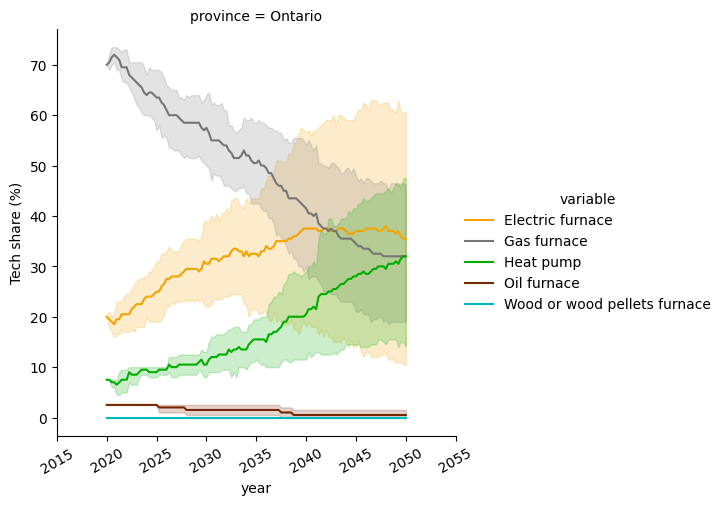

In [23]:
b_result.tech_shares_fig()

c:\src\canadopt\abetam\batch.py:619: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



<Axes: xlabel='year', ylabel='Appliance age'>

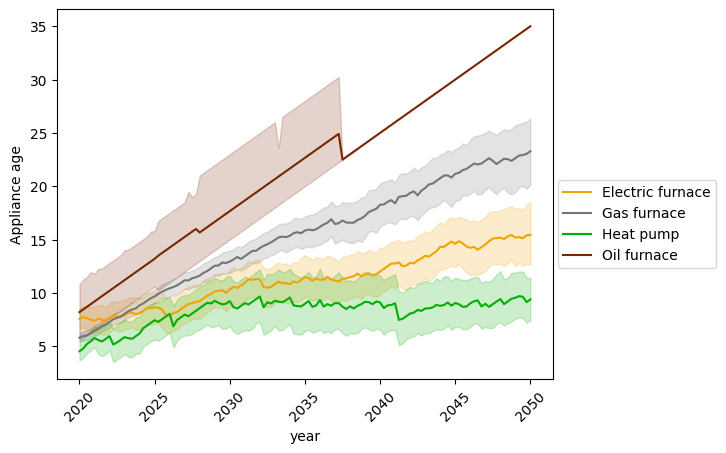

In [24]:
b_result.appliance_age_fig()

In [35]:
demand_df = b_result.mean_carrier_demand_df
demand_df.tail()

Fuels.NATURAL_GAS Fuels.HEATING_OIL  \
province year   hour                                       
Ontario  2050.0 48        1174372390.4        16776281.6   
                49        1605175872.0        22930444.8   
                50        1434500787.2        20492297.6   
                51        1453652889.6        20765892.8   
                52         510820889.6         7297238.4   

                     Fuels.WOOD_OR_WOOD_PELLETS Fuels.ELECTRICITY  
province year   hour                                               
Ontario  2050.0 48                          0.0      1520597568.0  
                49                          0.0      2123368550.4  
                50                          0.0      1880837132.8  
                51                          0.0      1907525580.8  
                52                          0.0       682358604.8

In [36]:

demand_df = demand_df.reset_index()
# colnames are integer years represented as string
demand_df["COPPER_colnames"] = (
    demand_df["province"] + "." + demand_df["year"].astype(int).astype(str)
)
demand_df = demand_df[["hour", "Electricity", "COPPER_colnames"]].pivot(
    index="hour", columns=["COPPER_colnames"], values="Electricity"
)
demand_df /= 1000  # kWh -> MWh


<Axes: xlabel='time'>

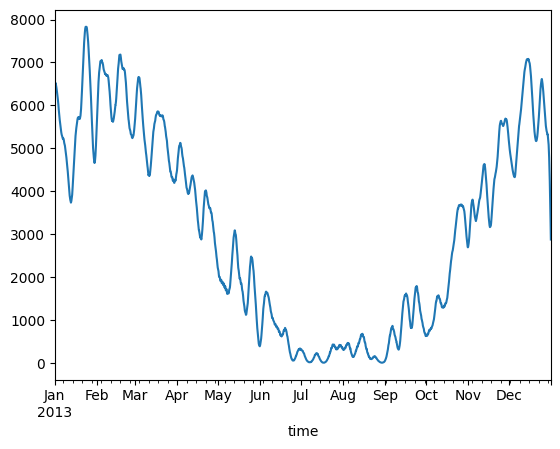

In [39]:
def spread_non_hourly_demand(demand_ts, province):
    demand_shape = pd.read_pickle("data/canada/timeseries/canada_agg_demand_shapes.pkl")[province]
    demand = demand_shape*demand_ts.sum()/demand_shape.sum()
    return demand

spread_non_hourly_demand(demand_df.iloc[:,0],"Ontario").plot()

In [42]:
def spread_model_demand(model_demand_df):
    if len(model_demand_df) > 8500:
        return model_demand_df
    series = []
    for col in model_demand_df.columns:
        province = col.split(".")[0]
        c_series = spread_non_hourly_demand(model_demand_df[col], province)
        c_series.name = col
        series.append(c_series)
    return pd.concat(series, axis=1)


def spread_non_hourly_demand(demand_ts, province):
    if len(demand_ts) > 8500:
        return demand_ts
    demand_shape = pd.read_pickle("data/canada/timeseries/canada_agg_demand_shapes.pkl")[province]
    demand = demand_shape*demand_ts.sum()/demand_shape.sum()
    return demand

spread_model_demand(demand_df)

,Ontario.2020,Ontario.2025,Ontario.2030,Ontario.2035,Ontario.2040,Ontario.2045,Ontario.2050
time,,,,,,,
2013-01-01 00:00:00,6499.229105,8215.523177,9365.419937,10437.663732,12091.417722,12512.966159,12388.173385
2013-01-01 01:00:00,6496.652138,8212.265693,9361.706515,10433.525162,12086.623432,12508.004723,12383.261430
2013-01-01 02:00:00,6503.077705,8220.388102,9370.965788,10443.844526,12098.577806,12520.375869,12395.509197
2013-01-01 03:00:00,6501.437360,8218.314580,9368.602042,10441.210156,12095.526044,12517.217711,12392.382536
2013-01-01 04:00:00,6508.587778,8227.353256,9378.905828,10452.693619,12108.828959,12530.984412,12406.011940
...,...,...,...,...,...,...,...
2013-12-31 19:00:00,3183.833472,4024.609266,4587.919120,5113.188445,5923.327189,6129.834761,6068.701448
2013-12-31 20:00:00,3099.906225,3918.518800,4466.979559,4978.402554,5767.185686,5968.249628,5908.727815
2013-12-31 21:00:00,3015.078070,3811.289518,4344.741786,4842.169820,5609.368099,5804.929977,5747.036963


In [26]:

px.bar(demand_long, x="year",y="value",color="variable", barmode="stack", template="plotly")

In [ ]:
b_result.adoption_details_fig()

In [ ]:
b_result.adoption_details_fig_facet(n_facet_cols=3)

## Visualising mutliple confidence intervals as shaded areas

In [ ]:
import config
config.TECHNOLOGY_COLORS

In [ ]:

# fig = adoption_plot_with_quantiles(df2plot, [0.68], mid_line="mean")
# fig.update_layout(width=800)

In [ ]:
import config
from matplotlib.colors import to_hex
import plotly.express as px
hex_colors = []
technology_colors = config.TECHNOLOGY_COLORS.copy()
for k,c in config.TECHNOLOGY_COLORS.items():
    c_hex = c
    # c_tuple = px.colors.unlabel_rgb(c)
    # c_tuple = [color/255 for color in c_tuple]
    # c_hex = to_hex(c_tuple)
    hex_colors.append(c_hex)
    technology_colors[k] = c_hex

technology_colors



## Loading a batch result

In [ ]:
import seaborn as sns
import plotly.express as px
from batch import BatchResult

r_result = BatchResult.from_directory(b_result_path)

ax = r_result.tech_shares_fig()
ax


# Segregation

In [ ]:
from components.model import TechnologyAdoptionModel
from components.technologies import merge_heating_techs_with_share
heating_techs = merge_heating_techs_with_share()

In [ ]:
n_agents = 1000
n_segregation_steps = 50

model = TechnologyAdoptionModel(n_agents, "Ontario")
income_segregation_dfs = model.perform_segregation(n_segregation_steps, capture_attribute="disposable_income")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

fig, ax = plt.subplots(figsize=(3,2))

img = income_segregation_dfs[-1].values
ax.imshow(img, label="income")
ax.set_yticks([])
ax.set_xticks([])
ax,img.shape,

In [ ]:
n_rows = int(n_segregation_steps**(1/2)) 
n_cols = n_rows +1


m_idx = list(product(range(n_rows), range(n_cols)))

fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(16,9))

for step, income_df in enumerate(income_segregation_dfs):
    row = m_idx[step][0]
    col = m_idx[step][1]

    # values are image data
    img = income_df.values
    axes[row][col].imshow(img)

    # set ticks to only show size
    # (because the axis here, are not really relevant)
    axes[row][col].set_yticks([0,img.shape[0]])
    axes[row][col].set_xticks([0,img.shape[1]])

    # relevant_ticks = ((income_df.values.shape()))

In [ ]:

fig, axes = plt.subplots(nrows=1,ncols=n_segregation_steps//5,figsize=(16,9))

for step, income_df in enumerate(income_segregation_dfs):
    if step%5==0:
        col = step//5

        # values are image data
        img = income_df.values
        axes[col].imshow(img)

        # set ticks to only show size
        # (because the axis here, are not really relevant)
        axes[col].set_yticks([])
        axes[col].set_xticks([])

# Parameter fit


In [ ]:
plotty_df = tech_score_df.reset_index().set_index(["variable","index"]).loc["total_score",:].reset_index()
plotty_df["AgentID"] = plotty_df["AgentID"]//10
# sns.relplot(plotty_df, x="Step", y="value", hue="index" )
fig = px.strip(plotty_df, x="Step",y="value",color="index",template="plotly", stripmode="group")
def opacitize_traces(t):
    t.opacity =0.8
fig.for_each_trace(lambda t: opacitize_traces(t))
fig.update_layout(width=800)

In [ ]:
tech_score_df = tech_score_df.reset_index()
tech_score_df = tech_score_df.loc[tech_score_df["variable"]!="total_score",:]
fig = px.strip(tech_score_df, x="Step",y="value", color="index", facet_row="variable",template="plotly")

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_trace(lambda t: opacitize_traces(t))
fig.update_layout(width=800)

In [ ]:
l_hist_shares = historic_tech_shares.loc[province,:].melt(ignore_index=False).reset_index()
l_hist_shares["iteration"] = "historic"
l_hist_shares["value"] *= 0.01

def parameter_fit_results(dfs: list[pd.DataFrame], second_id_var="iteration"):
    results = pd.concat(dfs)
    results.reset_index(names=["year"], inplace=True)
    long_results = results.melt(id_vars=["year",second_id_var])
    return long_results


def update_trace_opacity(trace: go.Trace):
    # TODO: add this variable in loop above
    n_fit_iterations = 10
    iteration = trace.name.split(",")[-1]
    if iteration == " historic":
        opacity = 1
        trace.width = 3
        
    else:
        try:
            opacity = int(iteration) * 1/n_fit_iterations
        except:
            pass
            opacity = float(iteration.strip())


    trace.opacity = opacity

pfit_res = parameter_fit_results(adoption_share_dfs)
pfit_res_historic = pd.concat( [pfit_res, l_hist_shares])

fig = px.line(pfit_res, x="year", y="value", color="variable", line_dash="iteration", template="plotly", )

fig.for_each_trace(lambda t: update_trace_opacity(t))

for i,tech in enumerate(historic_tech_shares.loc[province,:].columns):
    fig.add_trace(
        go.Scatter(
            x=historic_tech_shares.loc[province,tech].index,
            y=historic_tech_shares.loc[province,tech].values/100,
            mode="lines",
            name=f"{tech}, historic",
            line=dict(dash="solid", width=3, color=px.colors.qualitative.Plotly[i]),
        )
    )

fig.update_layout(width=800)

In [ ]:
# maybe decrease hp prices for increased adoption
# np.array([857.06,802.56,794.53,693.55,824.12])*0.7
# [599.942, 561.792, 556.171, 485.485, 576.884]

In [ ]:
adoption_detail_df = pd.concat(adoption_detail_dfs)
sns.relplot(adoption_detail_df,kind="line", x="Step", y="cumulative_amount", hue="tech", col="reason")
# sns.lineplot(adoption_detail_df, x="Step", y="cumulative_amount", hue="tech")

## Draw dependent random parameters (mcda weights)

weights for mcda need to be diverse across agents, and have to add up to 1.
This can be achieved, by drawing one weight $w_0$ from an assumed distribution D between 0 and 1, and then drawing $w_i$ from the same distribution with adapted boundaries as $1 - w_0$ for the upper bound. More formally, the equation for the upper bound of $w_i$ is:
$$ 1- \sum_{i-1} w_{i-1} $$



In [ ]:
from components.model import get_income_and_attitude_weights

all_dfs = []
for p_mode in [0.5, 0.7, 0.9]:
    _, weights_df = get_income_and_attitude_weights(10000, price_weight_mode=p_mode)
    weights_df["mode"] = p_mode
    # print(weights_df.head())
    all_dfs.append(weights_df.copy())

all_df = pd.concat(all_dfs)

fig = px.histogram(
    all_df.melt(id_vars=["mode"]),
    facet_col="variable",
    facet_row="mode",
    category_orders={
        "variable": ["cost_norm", "emissions_norm", "attitude"],
        "mode": [0.5, 0.7, 0.9][::-1],
    },
)
fig.update_layout(template="plotly", xaxis_title="test", width=800)

## parameter fit for mcda-weight's mode

In [ ]:
# new_modes
best_modes = pd.Series(
    {
        "Electric furnace": 0.788965,
        "Gas furnace": 0.388231,
        "Heat pump": 0.346424,
        "Oil furnace": 0.460226,
        "Wood or wood pellets furnace": 0.516056,
    }
)

In [ ]:
from batch import transform_dict_column
province = "Canada"
start_year = 2000

batch_parameters = {
    "N": [150],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "tech_attitude_dist_func":beta_with_mode_at, 
    "tech_attitude_dist_params":[best_modes.to_dict()],
    "n_segregation_steps": [30],
    "interact": [False],
}

adoption_dfs = []
for p_mode in [0.925, 0.9, 0.875, 0.85, ]:

    batch_parameters["price_weight_mode"] = p_mode

    results = batch_run(
        TechnologyAdoptionModel,
        batch_parameters,
        number_processes=None,
        max_steps=80,
        data_collection_period=1,
    )
    df = pd.DataFrame(results)
    df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
    df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
    df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
        columns=["variable", "RunId"], index="Step", values="value"
    )
    
    mean_df = pd.DataFrame()
    for col in df2plot.columns.get_level_values(0).unique():
        mean_df.loc[:,col] = df2plot[col].mean(axis=1)

    mean_df.index = TechnologyAdoptionModel.steps_to_years_static(start_year,range(81),1/4)
    mean_df["p_mode"] = p_mode
    adoption_dfs.append(mean_df)
    diff_sum = (h_tech_shares-mean_df).sum()

    
    total_abs_diff = diff_sum.abs().sum()
    print(p_mode,total_abs_diff)
    # print(f"finished iteration {i}")

mcda_fit_results = pd.concat(adoption_dfs)



In [ ]:
def update_trace_opacity(trace: go.Trace):
    # TODO: add this variable in loop above
    n_fit_iterations = 10
    iteration = trace.name.split(",")[-1]
    if iteration == " historic":
        opacity = 1
        trace.line.width = 3
        trace.line.dash = "solid"
        
    else:
        try:
            opacity = int(iteration) * 1/n_fit_iterations
        except:
            opacity = float(iteration.strip())
    trace.opacity = opacity


pfit_res = parameter_fit_results(adoption_dfs, second_id_var="p_mode")
pfit_res_historic = pd.concat( [pfit_res, l_hist_shares])
pfit_res_historic["p_mode"][pfit_res_historic["p_mode"].isna()] = "historic"
# pfit_res_historic.sort_values(by="p_mode", inplace=True)
fig = px.line(pfit_res_historic, x="year", y="value", color="variable", line_dash="p_mode", template="plotly", )

fig.for_each_trace(lambda t: update_trace_opacity(t))

fig.update_layout(width=800)

In [ ]:
from batch import BatchResult
from components.probability import beta_with_mode_at
# new_modes
best_modes = pd.Series(
    {
        "Electric furnace": 0.788965,
        "Gas furnace": 0.388231,
        "Heat pump": 0.346424,
        "Oil furnace": 0.460226,
        "Wood or wood pellets furnace": 0.516056,
    }
)

province = "Canada"

best_guess_parameters = {
    "N": [200],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "tech_attitude_dist_func":beta_with_mode_at, 
    "tech_attitude_dist_params":[best_modes.to_dict()],
    "n_segregation_steps": [30],
    "interact": [False],
    "price_weight_mode": 0.875
}
# best_guess_parameters.pop("tech_attitude_dist_func")
bResult = BatchResult.from_parameters(best_guess_parameters)

In [ ]:
ax = bResult.tech_shares_fig()

In [ ]:
from data.canada import nrcan_tech_shares_df
import config

historic_tech_shares = nrcan_tech_shares_df.copy()
historic_tech_shares.index = historic_tech_shares.index.swaplevel()
for tech in historic_tech_shares.columns:
    
    # x = historic_tech_shares.reset_index()["year"]
    y = historic_tech_shares.loc[province, tech]
    ax.ax.plot(y.index,y.values, "--", label=tech+" historic", color=config.TECHNOLOGY_COLORS[tech],)#) ax=ax.ax)
    # historic_tech_shares.loc[province,:].plot(kind="line", ax=ax.ax, color=config.TECHNOLOGY_COLORS)
# ax_ = historic_tech_shares.loc[province,:].plot(kind="line", ax=ax.ax, colormap=config.TECHNOLOGY_COLORS)
ax.ax.figure

In [ ]:
ax.ax.legend(loc=(1.01, 0.4))
ax.ax.figure.savefig("tuned_parameters.svg",format="svg")

In [ ]:
bResult.adoption_details_fig()

# Convert outputs to copper inputs

In [ ]:
# TODO: create batch run from 2020 until 2050
from batch import BatchResult

sample_params = {
    "N":50,
    "province": ["Ontario","Alberta"],
    "random_seed":[1,2,3,4],
    "start_year": 2020,
}

bResult = BatchResult.from_parameters(sample_params, max_steps=(2050-2020)*4)



In [ ]:
model_demand = bResult.mean_carrier_demand_df["Electricity"]
model_demand = model_demand.reset_index()
model_demand.head()
model_demand["COPPER_colnames"] = model_demand["province"]+"."+model_demand["year"].astype(int).astype(str)
model_demand = model_demand[["hour","Electricity","COPPER_colnames"]].pivot(index="hour",columns=["COPPER_colnames"], values="Electricity")
model_demand /= 1000 # kWh -> MWh
model_demand.head()

In [ ]:
projection_df = pd.read_csv("data/canada/timeseries/end-use-demand-2023.csv", index_col=0).query("Scenario=='Global Net-zero' and Variable=='Electricity'  and Sector!='Total End-Use'")
valid_years = (projection_df["Year"] % 5 == 0) & (projection_df["Year"]> 2019) | (projection_df["Year"] == 2021)

projection_df = projection_df.loc[valid_years,:]
projection_df.loc[:,"COPPER_colnames"] = projection_df["Region"] + "." + projection_df["Year"].astype("str")
projection_df.head()

In [ ]:
# group to Residential and rest
def agg_sectors(sector):
    if sector== "Residential":
        return sector
    else: 
        return "Comm_Trans_Industr"

projection_df["agg_sector"] = projection_df["Sector"].apply(agg_sectors)
annual_sector_PJ_prov_demand = projection_df.groupby(["agg_sector","COPPER_colnames"])["Value"].sum().reset_index()
annual_sector_PJ_prov_demand.head()

In [ ]:
# read copper demand profiles
copper_demand = pd.read_csv("data/canada/timeseries/COPPER_BAU_demand.csv", index_col=0)

copper_normalized_profiles = copper_demand/copper_demand.sum()
copper_normalized_profiles.head()

In [ ]:
# use annual demand to scale normalized profiles
test = {}
for i, row in annual_sector_PJ_prov_demand.query("agg_sector!='Residential'").iterrows():
    province = row["COPPER_colnames"].split(".")[0]
    if province not in copper_normalized_profiles.columns:
        continue
    rest_demand = row["Value"] * copper_normalized_profiles[province]
    test[row["COPPER_colnames"]] = rest_demand

In [ ]:
rest_demand_df = pd.DataFrame(test)
#                   J->Wh, P -> M
rest_demand_df *= (1/3600)*1e9
rest_demand_df.head()

In [ ]:
common_cols = set(rest_demand_df.columns).intersection(model_demand.columns)
# set(rest_demand_df.columns).difference(model_demand.columns)
copper_input = rest_demand_df.loc[:,list(common_cols)] + model_demand
copper_input

# Sensitivity for ...

## ... Electricity prices

Operationalisation: 
1) run a batch 
2) multiply electricity prices with `[0.5, 2]` 
3) run batches for that

In [ ]:
import pandas as pd
from batch import BatchResult
from components.probability import beta_with_mode_at


el_prices = pd.read_csv("data/canada/ca_electricity_prices.csv")

def multiply_el_prices(factor):
    return el_prices.copy().set_index("REF_DATE") * factor



In [ ]:
best_tech_modes = {
    "Electric furnace": 0.788965,
    "Gas furnace": 0.388231,
    "Heat pump": 0.346424,
    "Oil furnace": 0.460226,
    "Wood or wood pellets furnace": 0.516056,
}

batch_parameters = {
    "N": [79],
    "province": ["Ontario",],
    "random_seed": list(range(42, 48)),
    "tech_attitude_dist_func": beta_with_mode_at,
    "tech_attitude_dist_params": [best_tech_modes],
    "start_year": 2000,
    "price_weight_mode": 0.875,
}


for p in [0.5,1,2]:
    new_prices = multiply_el_prices(p)
    new_prices.to_csv("data/canada/ca_electricity_prices.csv")
    batch_result = BatchResult.from_parameters(
        batch_parameters, max_steps=80, force_rerun=True
    )
    batch_result.save()


In [ ]:
import pickle

demand_0 = pickle.load(open("results/main/52239d78559bcac68364e9514234d1da_0/mean_carrier_demand.pkl","rb"))
demand_0["el_price"] = 0.5
# el_price * 2
demand_1 = pickle.load(open("results/main/52239d78559bcac68364e9514234d1da_1/mean_carrier_demand.pkl","rb"))
demand_1["el_price"] = 1
# el_price * 0.5
demand_2 = pickle.load(open("results/main/52239d78559bcac68364e9514234d1da_2/mean_carrier_demand.pkl","rb"))
demand_2["el_price"] = 2

demands = pd.concat([demand_0, demand_1, demand_2]).set_index("el_price", append=True)


In [ ]:
import plotly.express as px

demands_long = demands.groupby(["province","year","el_price"]).sum().reset_index().melt(id_vars=["province","year","el_price"])
px.line(demands_long, x="year", y="value", color="variable", facet_col="el_price", template="plotly")

In [ ]:

tech_shares_0 = pd.read_csv("results/main/52239d78559bcac68364e9514234d1da_0/tech_shares_df.csv")
tech_shares_0["el_price"] = 0.5
tech_shares_1 = pd.read_csv("results/main/52239d78559bcac68364e9514234d1da_1/tech_shares_df.csv")
tech_shares_1["el_price"] = 1
tech_shares_2 = pd.read_csv("results/main/52239d78559bcac68364e9514234d1da_2/tech_shares_df.csv")
tech_shares_2["el_price"] = 2
tech_shares = pd.concat([tech_shares_0, tech_shares_1, tech_shares_2])
tech_shares_long = tech_shares.melt(id_vars=["RunId", "province","year", "el_price"])
tech_shares_long.head()

In [ ]:
import seaborn as sns
sns.relplot(tech_shares_long, x="year", y="value", hue="variable", col="el_price", kind="line")

## ... Appliance prices

In [ ]:
appliance_data = pd.read_csv("data/canada/heat_tech_params.csv").set_index(["variable","year"])

In [ ]:


best_tech_modes = {
    "Electric furnace": 0.788965,
    "Gas furnace": 0.388231,
    "Heat pump": 0.346424,
    "Oil furnace": 0.460226,
    "Wood or wood pellets furnace": 0.516056,
}

batch_parameters = {
    "N": [82],
    "province": ["Ontario",],
    "random_seed": list(range(42, 48)),
    "tech_attitude_dist_func": beta_with_mode_at,
    "tech_attitude_dist_params": [best_tech_modes],
    "start_year": 2000,
    "price_weight_mode": 0.875,
}

for p_mod in [0.5, 1, 1.5]:
    appliance_data.loc["specific_cost","Heat pump"] = (appliance_data.loc["specific_cost","Heat pump"].astype(float) * p_mod).values
    appliance_data.to_csv("data/canada/heat_tech_params.csv")

    batch_result = BatchResult.from_parameters(
        batch_parameters, max_steps=80, force_rerun=True
    )
    batch_result.save()

In [ ]:
demand_0 = pickle.load(open("results/main/5cb5ed9fe20269a663881f7aac376e76_0/mean_carrier_demand.pkl","rb"))
demand_0["hp_price"] = 0.75
# hp_price * 2
demand_1 = pickle.load(open("results/main/5cb5ed9fe20269a663881f7aac376e76_1/mean_carrier_demand.pkl","rb"))
demand_1["hp_price"] = 1
# hp_price * 0.5
demand_2 = pickle.load(open("results/main/5cb5ed9fe20269a663881f7aac376e76_2/mean_carrier_demand.pkl","rb"))
demand_2["hp_price"] = 1.5

demands = pd.concat([demand_0, demand_1, demand_2]).set_index("hp_price", append=True)

In [ ]:

demands_long = demands.groupby(["province","year","hp_price"]).sum().reset_index().melt(id_vars=["province","year","hp_price"])
px.line(demands_long, x="year", y="value", color="variable", facet_col="hp_price", template="plotly")

In [ ]:

tech_shares_0 = pd.read_csv("results/main/5cb5ed9fe20269a663881f7aac376e76_0/tech_shares_df.csv")
tech_shares_0["hp_price"] = 0.75
tech_shares_1 = pd.read_csv("results/main/5cb5ed9fe20269a663881f7aac376e76_1/tech_shares_df.csv")
tech_shares_1["hp_price"] = 1
tech_shares_2 = pd.read_csv("results/main/5cb5ed9fe20269a663881f7aac376e76_2/tech_shares_df.csv")
tech_shares_2["hp_price"] = 1.5
tech_shares = pd.concat([tech_shares_0, tech_shares_1, tech_shares_2])
tech_shares_long = tech_shares.melt(id_vars=["RunId", "province","year", "hp_price"])
tech_shares_long.head()
sns.relplot(tech_shares_long, x="year", y="value", hue="variable", col="hp_price", kind="line")

## .. both? can i this?

In [ ]:
appliance_data = pd.read_csv("data/canada/heat_tech_params.csv").set_index(["variable","year"])

def multiply_hp_price(hp_p):
    local_appl_data = appliance_data.copy()
    local_appl_data.loc["specific_cost","Heat pump"] = (local_appl_data.loc["specific_cost","Heat pump"].astype(float) * hp_p).values
    return local_appl_data


el_prices = pd.read_csv("data/canada/ca_electricity_prices.csv")

def multiply_el_prices(factor):
    return el_prices.copy().set_index("REF_DATE") * factor


best_tech_modes = {
    "Electric furnace": 0.788965,
    "Gas furnace": 0.388231,
    "Heat pump": 0.346424,
    "Oil furnace": 0.460226,
    "Wood or wood pellets furnace": 0.516056,
}

batch_parameters = {
    "N": [49],
    "province": ["Ontario",],
    "random_seed": list(range(42, 50)),
    "tech_attitude_dist_func": beta_with_mode_at,
    "tech_attitude_dist_params": [best_tech_modes],
    "start_year": 2000,
    "price_weight_mode": 0.875,
}

price_modification = [0.5,1,2]


for el_p in price_modification:
    for hp_p in price_modification:
        new_prices = multiply_el_prices(el_p)
        new_prices.to_csv("data/canada/ca_electricity_prices.csv")

        new_appliance_data = multiply_hp_price(hp_p)
        new_appliance_data.to_csv("data/canada/heat_tech_params.csv")
        print(f"{el_p=}, {hp_p=}")
        print(f"{new_prices.mean().mean()=}")
        print("mean spec. hp cost=",new_appliance_data.loc["specific_cost","Heat pump"].mean())
        batch_result = BatchResult.from_parameters(
            batch_parameters, max_steps=80, force_rerun=True
        )
        batch_result.save()


In [ ]:
import numpy as np
from itertools import combinations, permutations, product

price_mod_perms = list(product(price_modification,price_modification))

le_shares = []
le_demands = []
for i in range(1,10):
    shares = pd.read_csv(f"results/main/b7d9839db6cb0ad1e20ad645503851d8_{i}/tech_shares_df.csv")
    shares["el_price"] = price_mod_perms[i-1][0]
    shares["hp_price"] = price_mod_perms[i-1][1]
    le_shares.append(shares)

    demand = pickle.load(open(f"results/main/b7d9839db6cb0ad1e20ad645503851d8_{i}/mean_carrier_demand.pkl","rb"))
    demand["el_price"] = price_mod_perms[i-1][0]
    demand["hp_price"] = price_mod_perms[i-1][1]
    le_demands.append(demand)

tech_shares = pd.concat(le_shares)

In [ ]:
demands = pd.concat(le_demands)
demands_long = demands.groupby(["province","year","hp_price","el_price"]).sum().reset_index().melt(id_vars=["province","year","hp_price","el_price"])
fig = px.line(demands_long, x="year", y="value", color="variable", facet_col="hp_price",facet_row="el_price", template="plotly")

fig.update_layout(width=600, height=600)

In [ ]:
tech_shares_long = tech_shares.melt(id_vars=["RunId", "province","year", "hp_price","el_price"])
# tech_shares_long.head()
sns.relplot(tech_shares_long, x="year", y="value", hue="variable", col="hp_price", row="el_price",kind="line")